In [50]:
import pandas as pd
import seaborn as sns
import numpy as np 
import pathlib
import json

In [58]:
is_path = "./results/"
p = pathlib.Path(is_path)
data = pd.DataFrame()
files = []

for i in p.glob('**/*.csv'):
    name = i.name
    splits = name.split("_")
    partial = pd.read_csv(i.absolute())
    drop3_one_class = splits[0]
    db = splits[1].split(".csv")[0]
    partial["database"] = db
    print(db, drop3_one_class, partial['tp'].mean(), partial['tn'].mean())
    partial["drop3_one_class"] = drop3_one_class
    data = pd.concat([data, partial], ignore_index = True)
    print("finish", db, drop3_one_class)
    

fraudk boundaries 254.33965672990064 38368.41056910569
finish fraudk boundaries
pageblocks boundaries 271.88074074074075 1459.1533333333334
finish pageblocks boundaries
fraudk one 255.01157407407408 38541.588425925926
finish fraudk one
pageblocks one 271.87925925925924 1455.4814814814815
finish pageblocks one


In [65]:
data.columns

Index(['instanceSelection', 'lshMEthod', 'sizeBucket', 'ands', 'ors',
       'imbalance', 'neigh', 'subBuckets', 'distance', 'isMethod', 'trees',
       'depth', 'type', 'k', 'tp', 'tn', 'fp', 'fn', 'sensibility',
       'specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'wtdAcc',
       'AreaROC', 'timeLSH', 'timeIS', 'buckets', 'buckMax', 'buckMin',
       'buckAvg', 'reduction', 'database', 'drop3_one_class'],
      dtype='object')

In [60]:
factorsIS = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'drop3_one_class', 'database']
measures = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'timeIS']
factorsModel = ['trees', 'depth']


def get_best_for(g, measures = measures, meas = 'F1', ascending=False, factorsModel= factorsModel):
    test = g.copy()
    test = test[test['type'] == 'Test']
    best = test.groupby(factorsModel)[measures].mean()
    best.sort_values(by = meas, ascending = ascending, inplace= True)
    best['type'] = 'Test'
    params = best.head(1).copy().reset_index()[factorsModel].to_dict('records')[0]
    params['type'] = 'Train'
    train = data.loc[(data[list(params)] == pd.Series(params)).all(axis=1)]
    tr_best = train.groupby(factorsModel)[measures].mean()
    tr_best.sort_values(by = meas, ascending = ascending, inplace= True) 
    tr_best['type'] = 'Train'
    return(pd.concat([best.head(1), tr_best.head(1)]))
    

In [61]:
bests_is = data.groupby(factorsIS).apply(get_best_for).reset_index()

In [62]:
data_to_plot = bests_is[bests_is.type == 'Test'].copy()

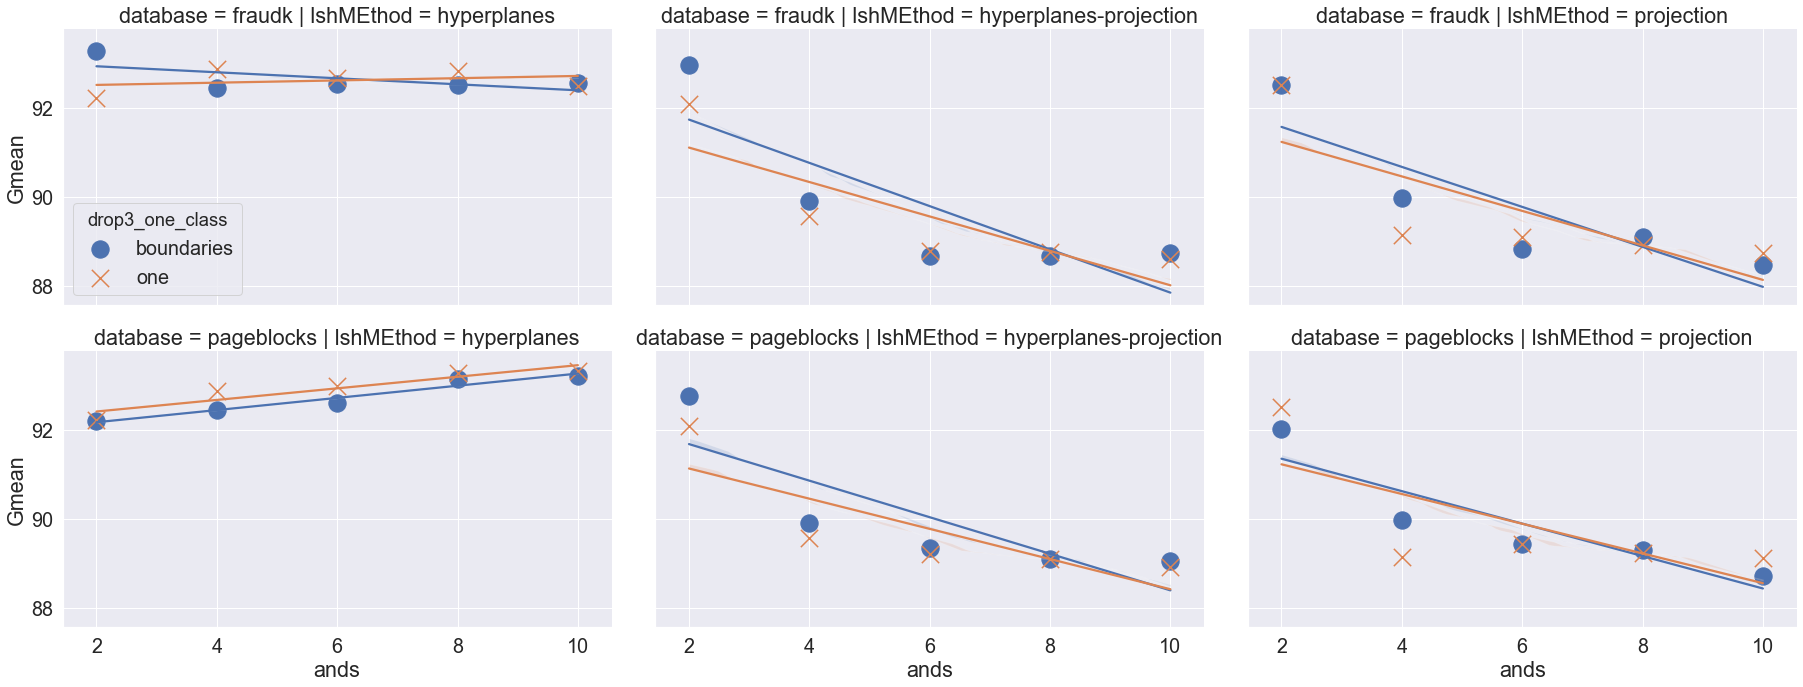

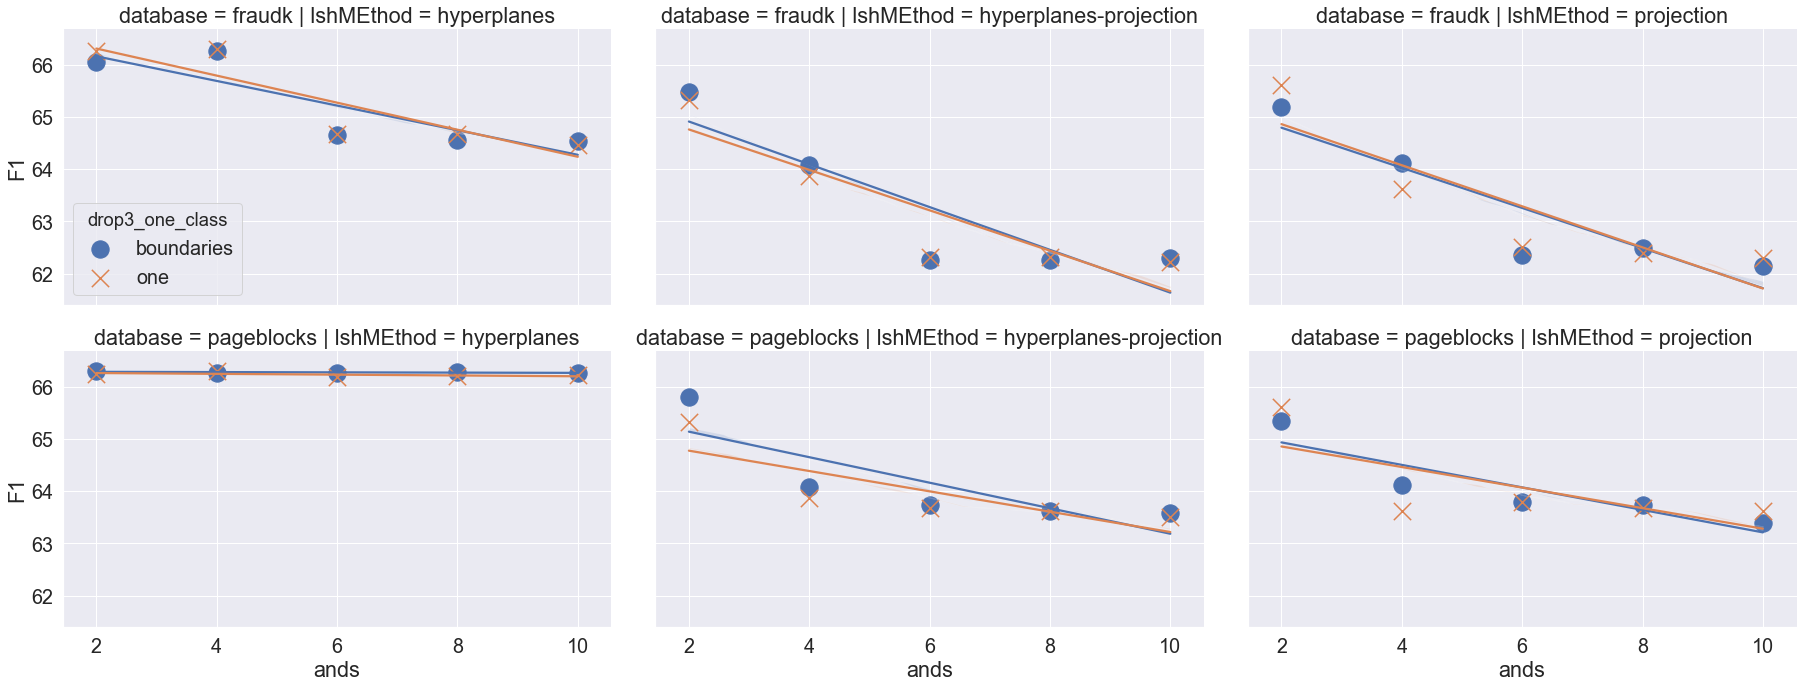

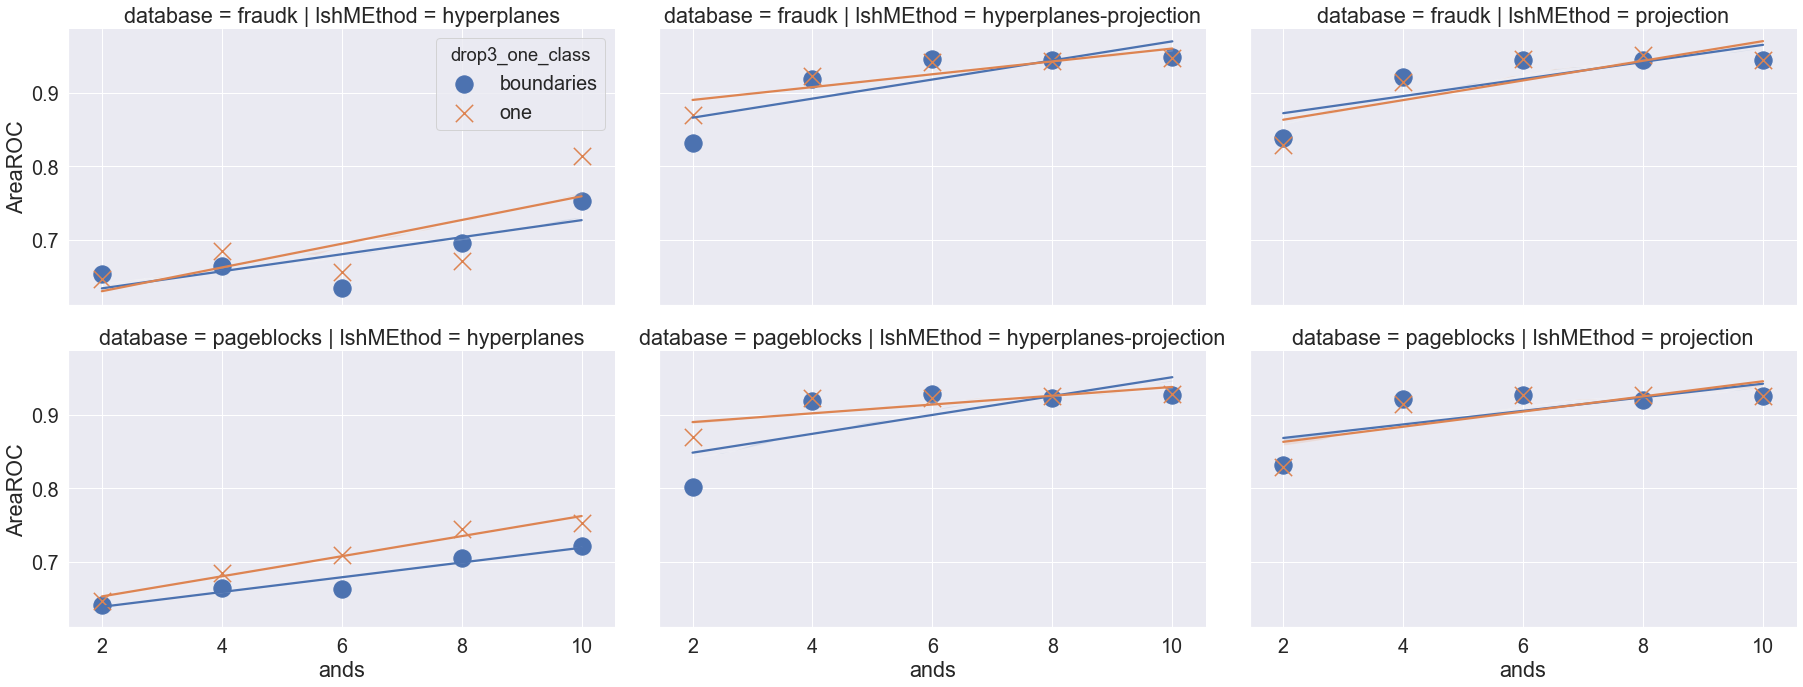

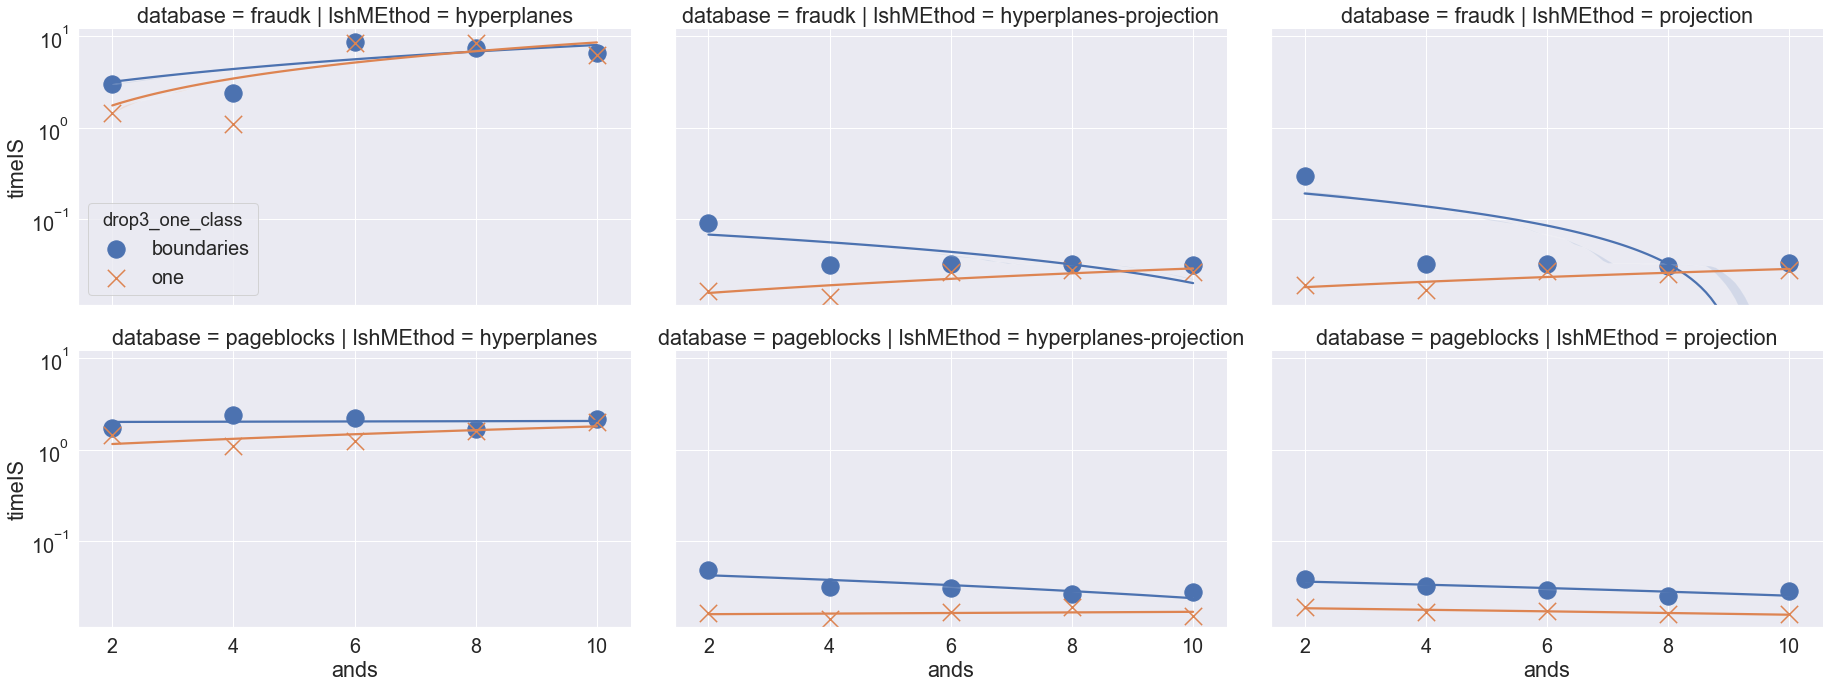

In [75]:
sns.set(font_scale=1.8)
legend_out = False
markers=["o", "x"]
scatter_kws={"s": 300}
    
sns.lmplot(x="ands", y="Gmean", col = 'lshMEthod', row = 'database', aspect=1.7, hue = 'drop3_one_class',  data=data_to_plot,
                 x_estimator=np.mean, ci = 0.95, legend_out=legend_out, markers=markers, scatter_kws=scatter_kws)

sns.lmplot(x="ands", y="F1", col = 'lshMEthod', row = 'database', aspect=1.7, hue = 'drop3_one_class',  data=data_to_plot,
                 x_estimator=np.mean, ci = 0.95, legend_out=legend_out, markers=markers, scatter_kws=scatter_kws)

sns.lmplot(x="ands", y="AreaROC", col = 'lshMEthod',row = 'database', aspect=1.7, hue = 'drop3_one_class',  data=data_to_plot,
                 x_estimator=np.mean, ci = 0.95, legend_out=legend_out, markers=markers, scatter_kws=scatter_kws)


g = sns.lmplot(x="ands", y="timeIS", col = 'lshMEthod',row = 'database', aspect=1.7, hue = 'drop3_one_class',  data=data_to_plot,
                 x_estimator=np.mean, ci = 0.95, legend_out=legend_out, markers=markers, scatter_kws=scatter_kws)

g.set(yscale="log")

# Analysis of bucket with error

In [4]:
bucket = pd.read_csv("bucket_with_issues.csv", sep = '|', header = None)
bucket.columns = ['features', 'id', 'label']
bucket['features_vector'] = bucket.features.str.split(",")
features_len = len(bucket.loc[0, 'features_vector'])
features_names = [f'PC_{i}' for i in range(features_len)]
vector_df = pd.DataFrame(bucket['features_vector'].to_list(), columns=features_names)
vector_df = vector_df.apply(pd.to_numeric)
vector_df['features'] = vector_df.apply(lambda row : np.array([row[n] for n in features_names]), axis = 1)
bucket = pd.concat([bucket.drop('features', axis = 1), vector_df], axis = 1, ignore_index=False)

In [5]:
bucket.dtypes

id                   int64
label                int64
features_vector     object
PC_0               float64
PC_1               float64
PC_2               float64
PC_3               float64
PC_4               float64
PC_5               float64
PC_6               float64
PC_7               float64
PC_8               float64
PC_9               float64
PC_10              float64
PC_11              float64
PC_12              float64
PC_13              float64
PC_14              float64
PC_15              float64
PC_16              float64
PC_17              float64
PC_18              float64
PC_19              float64
PC_20              float64
PC_21              float64
PC_22              float64
PC_23              float64
PC_24              float64
PC_25              float64
PC_26              float64
PC_27              float64
PC_28              float64
features            object
dtype: object

In [6]:
bucket.groupby('label')['id'].nunique()

label
0    1181
1       3
Name: id, dtype: int64

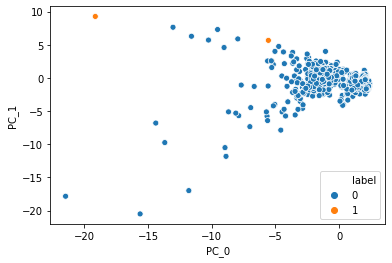

In [7]:
sns.scatterplot(x='PC_0', y='PC_1', hue = 'label', data = bucket)

In [8]:
bucket[['features', 'id', 'label']].to_parquet('test_bucket.parquet', flavor = 'spark')

In [9]:
bucket.id.value_counts()

30840     2
87345     2
36681     2
40959     1
41619     1
         ..
40251     1
40253     1
128318    1
44358     1
57345     1
Name: id, Length: 1184, dtype: int64

In [54]:
bucket[bucket.id==15619]

,id,label,features_vector,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,...,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,features
718,15619,0,"[1.99593842815516, 0.0415056489610134, -1.6266...",1.995938,0.041506,-1.626617,0.35973,0.328712,-0.670507,0.070409,...,-0.157064,-0.298886,-0.842195,0.345810,0.657588,-0.333355,0.142894,-0.071543,-0.037694,"[1.99593842815516, 0.0415056489610134, -1.6266..."
739,15619,0,"[-1.1862842430525, -0.195967605015851, 0.52276...",-1.186284,-0.195968,0.522765,-1.65665,-0.160922,-0.355847,0.244029,...,-0.277202,-0.236395,-0.632779,-0.059676,-0.474141,0.203918,0.969991,-0.158882,-0.057474,"[-1.1862842430525, -0.195967605015851, 0.52276..."


In [36]:
61641 in bucket.id.unique()

False